In [33]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)
import torchvision
from PIL import Image
import imageio
import os
import csv
import numpy as np

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c) #  t_c — температура в градусах по Цельсию
t_u = torch.tensor(t_u) #  t_u — в неизвестных единицах измерения

In [36]:
def model(t_u, w, b):
  return w * t_u + b

In [37]:
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [38]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [39]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [40]:
delta = 0.1

loss_rate_of_change_w = \
  (loss_fn(model(t_u, w + delta, b), t_c) -
   loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [41]:
loss_rate_of_change_b = \
  (loss_fn(model(t_u, w, b + delta), t_c) -
   loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

learning_rate = 1e-2
b = b - learning_rate * loss_rate_of_change_b

In [42]:
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # делитель получается из производной мат ожидания
  return dsq_diffs

In [43]:
def dmodel_dw(t_u, w, b):
  return t_u

def dmodel_db(t_u, w, b):
  return 1.0

In [44]:
# Собирая все воедино, получаем функцию, возвращающую градиент потерь относительно w и b

In [45]:
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [46]:
def training_loop(n_epoches, learning_rate, params, t_u, t_c,  print_params=True):
  for epoch in range(1, n_epoches + 1):
    w, b = params

    t_p = model(t_u, w, b) # прямой проход
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, w, b) # обратный проход
    params = params - learning_rate * grad

    if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
    if epoch in {4, 12, 101}:
            print('...')
  return params


In [47]:
t_un = 0.1 * t_u

params = training_loop(
    n_epoches=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u=t_un,
    t_c=t_c
)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])


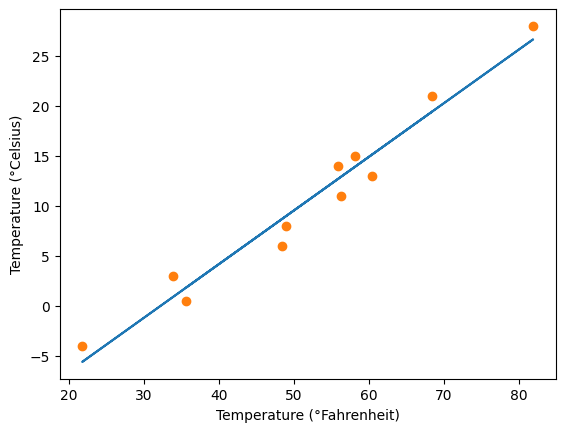

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)
fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## Autograd

In [49]:
def model(t_u, w, b):
  return t_u * w + b

def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

params = torch.tensor([1.0, 0.0], requires_grad=True)

In [50]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

In [51]:
def training_loop(n_epoches, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epoches + 1):
    if params.grad is not None:
      params.grad.zero_()
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    loss.backward()

    with torch.no_grad():
      params -= learning_rate * params.grad
    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [52]:
training_loop(
    n_epoches=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0], requires_grad=True),
    t_u=t_un,
    t_c=t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers

In [53]:
import torch.optim as optim

In [54]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indicies = torch.randperm(n_samples)

train_indicies = shuffled_indicies[:-n_val]
val_indicies = shuffled_indicies[-n_val:]

train_indicies, val_indicies

(tensor([0, 6, 2, 7, 1, 9, 4, 5, 3]), tensor([10,  8]))

In [55]:
train_t_u = t_u[train_indicies]
train_t_c = t_c[train_indicies]

val_t_u = t_u[val_indicies]
val_t_c = t_c[val_indicies]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [56]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [57]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1>
    val_t_u = val_t_un, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 75.7952, Validation loss 100.9256
Epoch 2, Training loss 38.2342, Validation loss 44.6465
Epoch 3, Training loss 31.5485, Validation loss 32.3576
Epoch 500, Training loss 6.4860, Validation loss 11.6878
Epoch 1000, Training loss 3.0221, Validation loss 7.4872
Epoch 1500, Training loss 2.5218, Validation loss 6.1733
Epoch 2000, Training loss 2.4496, Validation loss 5.7147
Epoch 2500, Training loss 2.4391, Validation loss 5.5463
Epoch 3000, Training loss 2.4376, Validation loss 5.4832


tensor([  5.2245, -16.4587], requires_grad=True)

In [58]:
import torch.nn as nn

linear_model = nn.Linear(1,1)
linear_model(t_un_val)


NameError: ignored